# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [793]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [794]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [795]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [796]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [797]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [798]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [799]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [800]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [801]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [802]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [803]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [804]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [805]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [806]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [807]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [808]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [809]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [810]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [811]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [812]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [813]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [814]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:36<00:00, 2411.38it/s]


In [815]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# preprocessing summary

In [816]:
from tqdm import tqdm
preprocessed_Summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_Summary.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:21<00:00, 4028.14it/s]


# [4] Featurization

# to prevent data leakage we are dividing reviews than vectorize it

In [817]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
p= final['Score']
X_1, X_test, y_1, y_test = model_selection.train_test_split(preprocessed_reviews, p, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = model_selection.train_test_split(X_1, y_1, test_size=0.3)

## [4.1] BAG OF WORDS

In [818]:
#BoW
count_vect = CountVectorizer(min_df=10) #in scikit-learn CountVectorizer(min_df=10, max_features=500) 
X_tr1=count_vect.fit_transform(X_tr)
X_cv1=count_vect.transform(X_cv)
X_test1=count_vect.transform(X_test)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

print("the type of count vectorizer ",type(X_tr1))
print("the shape of out text BOW vectorizer ",X_tr1.get_shape())
print("the number of unique words ", X_tr1.get_shape()[1])

some feature names  ['aback', 'abdominal', 'ability', 'able', 'abroad', 'absence', 'absent', 'absolute', 'absolutely', 'absorb']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (43008, 8097)
the number of unique words  8097


In [819]:
print("the number of unique words ", X_cv1.shape)

the number of unique words  (18433, 8097)


## [4.3] TF-IDF

In [820]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_tr2=tf_idf_vect.fit_transform(X_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_cv2=tf_idf_vect.transform(X_cv)
X_test2=tf_idf_vect.transform(X_test)

print("the type of count vectorizer ",type(X_tr2))
print("the shape of out text TFIDF vectorizer ",X_tr2.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_tr2.get_shape()[1])

some sample features(unique words in the corpus) ['aback', 'abdominal', 'ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (43008, 25511)
the number of unique words including both unigrams and bigrams  25511


# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# AUC FOR VARIOUS PARAMETER

In [821]:
import math

In [822]:
param =  [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
param1 = [math.log10(i) for i in param]
def plot_auc(train_auc_list,cv_auc_list):
    plt.title("AUC vs hyperparameter")
    plt.plot(param1,train_auc_list,label="Train AUC")
    plt.xlabel("log alpha")
    plt.ylabel("Area Under Curve")
    plt.plot(param1,cv_auc_list,label="Validation AUC")
    +
    plt.show()

# ROC

In [823]:
from sklearn.metrics import roc_curve
def plot_roc(Y_test,predict_y_test,Y_train,predict_y_train):
    fpr1,tpr1,threshold1 = roc_curve(Y_test,predict_y_test) # For test dataset
    fpr2,tpr2,threshold2 = roc_curve(Y_train,predict_y_train) # For train dataset
    plt.title("ROC curve")
    plt.plot([0,1],[0,1])
    plt.plot(fpr1,tpr1,label="Validation AUC")
    plt.plot(fpr2,tpr2,label="Train AUC")
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.legend()
    plt.show()

# CONFUSION MATRIX

In [824]:
def confusion_matrix_plot(test_y, predict_y):
    # C stores the confusion matrix 
    C = confusion_matrix(test_y, predict_y)
    
    # Class labels 
    labels_x = ["Predicted No","Predicted Yes"]
    labels_y = ["Actual No","Actual Yes"]
    
    cmap=sns.light_palette("orange")
    print("Confusion matrix")
    plt.figure(figsize=(4,4))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_x, yticklabels=labels_y)
    plt.show()

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [825]:
# Please write all the code with proper documentation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
train_auc_list=[]
cv_auc_list=[]
for i in tqdm(param):
    clf = BernoulliNB(alpha=i, binarize=0.0, fit_prior=True, class_prior=None)
    clf.fit(X_tr1, y_tr)
    trprob=clf.predict_proba(X_tr1)[:,1] # Returns probability of positive class
    cvprob = clf.predict_proba(X_cv1)[:,1] 
    auctr = roc_auc_score(y_tr,trprob)#auc of tranning data
    auccv = roc_auc_score(y_cv,cvprob)#auc of cross validation data
    train_auc_list.append(auctr)
    cv_auc_list.append(auccv)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  8.77it/s]


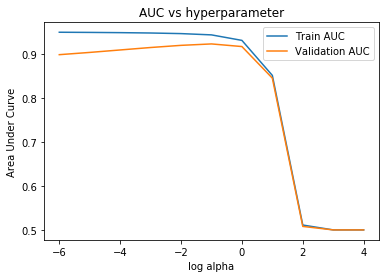

In [826]:
plot_auc(train_auc_list,cv_auc_list)

best hyperparameter is log(x)=-1 ,i.e. alpha=0.1 

In [827]:
clf = BernoulliNB(alpha=0.1, binarize=0.0, fit_prior=True, class_prior=None)
clf.fit(X_tr1, y_tr)
trpred=clf.predict(X_tr1)
testpred = clf.predict(X_test1)
trprob=clf.predict_proba(X_tr1)[:,1] # Returns probability of positive class
testprob = clf.predict_proba(X_test1)[:,1] 
auctr = roc_auc_score(y_tr,trprob)#auc of tranning data
auctest = roc_auc_score(y_test,testprob)#auc of cross validation data


In [828]:
auctest


0.9218119915452573

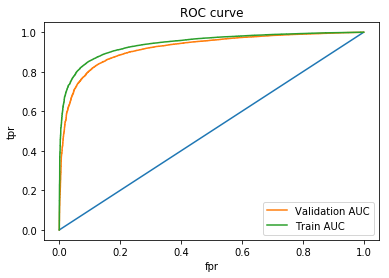

In [829]:
plot_roc(y_test,testprob,y_tr,trprob)

# confusion matrix for train data

Confusion matrix


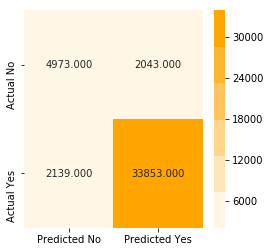

In [830]:
confusion_matrix_plot(y_tr, trpred)

# confusion matrix for test data

Confusion matrix


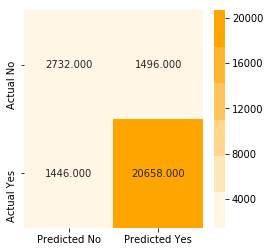

In [831]:
confusion_matrix_plot(y_test, testpred)

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [832]:
top_pos_feature=w[0].argsort

nastiest
not
like
good
great
one
taste
love
flavor
would


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [833]:
x = clf.feature_log_prob_[0,:]
q=np.argsort(x)
r = count_vect.get_feature_names()
for i in range(10):
    print(r[q[-i]])

mmmmm
not
like
would
taste
product
one
good
no
flavor


# using summary and length of text as feature

# review length

In [834]:
tr_review_len = np.zeros(len(X_tr))
i=0
for sent in X_tr:
    tr_review_len[i] = len(sent)
    i += 1

print(tr_review_len.shape)

(43008,)


In [835]:
cv_review_len = np.zeros(len(X_cv))
i=0
for sent in X_cv:
    tr_review_len[i] = len(sent)
    i += 1

print(cv_review_len.shape)

(18433,)


In [836]:
test_review_len = np.zeros(len(X_test))
i=0
for sent in X_test:
    test_review_len[i] = len(sent)
    i += 1

print(test_review_len.shape)

(26332,)


In [837]:
from scipy.sparse import hstack

# now we will add review length as a new feature to train  data set

A = (tr_review_len[np.newaxis, :]).T#conversion of 1-d array to  2-d array

X_tr1 = hstack([X_tr1,A])
print(X_tr1.shape)

(43008, 8098)


In [838]:
B = (cv_review_len[np.newaxis, :]).T

X_cv1 = hstack([X_cv1,B])
print(X_cv1.shape)

(18433, 8098)


In [839]:
C= (test_review_len[np.newaxis, :]).T

X_test1 = hstack([X_test1,C])
print(X_test1.shape)

(26332, 8098)


In [840]:
train_auc_listln=[]
cv_auc_listln=[]
for i in tqdm(param):
    clf = BernoulliNB(alpha=i, binarize=0.0, fit_prior=True, class_prior=None)
    clf.fit(X_tr1, y_tr)
    trprob=clf.predict_proba(X_tr1)[:,1] # Returns probability of positive class
    cvprob = clf.predict_proba(X_cv1)[:,1] 
    auctr = roc_auc_score(y_tr,trprob)#auc of tranning data
    auccv = roc_auc_score(y_cv,cvprob)#auc of cross validation data
    train_auc_listln.append(auctr)
    cv_auc_listln.append(auccv)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.22it/s]


In [841]:
clf = BernoulliNB(alpha=0.1, binarize=0.0, fit_prior=True, class_prior=None)
clf.fit(X_tr1, y_tr)
trpred=clf.predict(X_tr1)
testpred = clf.predict(X_test1)
trprob=clf.predict_proba(X_tr1)[:,1] # Returns probability of positive class
testprob = clf.predict_proba(X_test1)[:,1] 
auctr = roc_auc_score(y_tr,trprob)#auc of tranning data
auctest = roc_auc_score(y_test,testprob)#auc of cross valida

In [842]:
auctest

0.9218230449092293

# taking summary as feature

In [843]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
S_1, S_test = model_selection.train_test_split(preprocessed_Summary, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
S_tr, S_cv = model_selection.train_test_split(S_1, test_size=0.3)

In [844]:
count_vect = CountVectorizer(min_df=10) 
S_tr1=count_vect.fit_transform(S_tr)
S_cv1=count_vect.transform(S_cv)
S_test1=count_vect.transform(S_test)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

print("the type of count vectorizer ",type(S_tr1))
print("the shape of out text BOW vectorizer ",S_tr1.get_shape())
print("the number of unique words ", S_tr1.get_shape()[1])

some feature names  ['absolute', 'absolutely', 'acid', 'acidic', 'actually', 'add', 'added', 'addict', 'addicted', 'addicting']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (43008, 1501)
the number of unique words  1501


In [845]:
# now we will add vectorized review as a new feature to train  data set
X_trnew = hstack([X_tr1,S_tr1])
print(X_trnew.shape)

(43008, 9599)


In [846]:
X_cvnew = hstack([X_cv1,S_cv1])
print(X_cvnew.shape)

(18433, 9599)


In [847]:
X_testnew = hstack([X_test1,S_test1])
print(X_testnew.shape)

(26332, 9599)


In [848]:
train_auc_listnew=[]
cv_auc_listnew=[]
for i in tqdm(param):
    clf = BernoulliNB(alpha=i, binarize=0.0, fit_prior=True, class_prior=None)
    clf.fit(X_trnew, y_tr)
    trprob=clf.predict_proba(X_trnew)[:,1] # Returns probability of positive class
    cvprob = clf.predict_proba(X_cvnew)[:,1] 
    auctr = roc_auc_score(y_tr,trprob)#auc of tranning data
    auccv = roc_auc_score(y_cv,cvprob)#auc of cross validation data
    train_auc_listnew.append(auctr)
    cv_auc_listnew.append(auccv)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.48it/s]


In [849]:
clf = BernoulliNB(alpha=0.1, binarize=0.0, fit_prior=True, class_prior=None)
clf.fit(X_trnew, y_tr)
trpred=clf.predict(X_trnew)
testpred = clf.predict(X_testnew)
trprob=clf.predict_proba(X_trnew)[:,1] # Returns probability of positive class
testprob = clf.predict_proba(X_testnew)[:,1] 
auctr = roc_auc_score(y_tr,trprob)#auc of tranning data
auctest = roc_auc_score(y_test,testprob)#auc of cross valida

In [850]:
auctest


0.9189016878925497

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [851]:
# Please write all the code with proper documentation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
train_auc_list1=[]
cv_auc_list1=[]
for i in tqdm(param):
    clf = BernoulliNB(alpha=i, binarize=0.0, fit_prior=True, class_prior=None)
    clf.fit(X_tr2, y_tr)
    trprob=clf.predict_proba(X_tr2)[:,1] # Returns probability of positive class
    cvprob = clf.predict_proba(X_cv2)[:,1] 
    auctr = roc_auc_score(y_tr,trprob)#auc of tranning data
    auccv = roc_auc_score(y_cv,cvprob)#auc of cross validation data
    train_auc_list1.append(auctr)
    cv_auc_list1.append(auccv)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.84it/s]


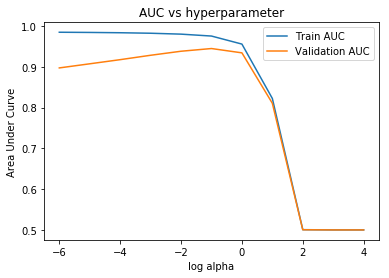

In [852]:
plot_auc(train_auc_list1,cv_auc_list1)

the best hyperparameter is log(x)=-1 i.e. 0.1

In [853]:
clf = BernoulliNB(alpha=0.1, binarize=0.0, fit_prior=True, class_prior=None)
clf.fit(X_tr2, y_tr)
trpred=clf.predict(X_tr2)
testpred = clf.predict(X_test2)
trprob=clf.predict_proba(X_tr2)[:,1] # Returns probability of positive class
testprob = clf.predict_proba(X_test2)[:,1] 
auctr = roc_auc_score(y_tr,trprob)#auc of tranning data
auctest = roc_auc_score(y_test,testprob)#auc of cross validation data

In [854]:
auctest

0.9439846758644351

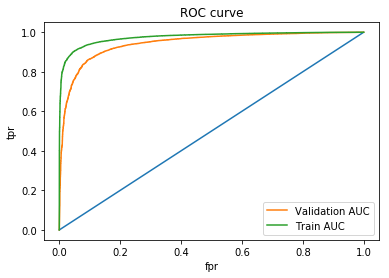

In [855]:
plot_roc(y_test,testprob,y_tr,trprob)

# Confusion matrix for train data

Confusion matrix


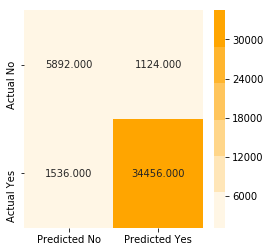

In [856]:
confusion_matrix_plot(y_tr, trpred)

# Confusion matrix for test data

Confusion matrix


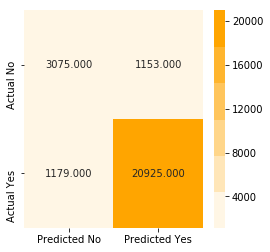

In [857]:
confusion_matrix_plot(y_test, testpred)

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [858]:
w = clf.feature_log_prob_[1,:]
p=np.argsort(w)
r = tf_idf_vect.get_feature_names()
for i in range(10):
    print(r[p[-i]])

gone bad
not
like
good
great
one
taste
love
flavor
would


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [859]:
x = clf.feature_log_prob_[0,:]
q=np.argsort(x)
for i in range(10):
    print(r[q[-i]])

stores would
not
like
would
taste
product
one
good
no
flavor


# taking summary and review as feature

In [860]:
X_tr2 = hstack([X_tr2,A])
print(X_tr2.shape)

(43008, 25512)


In [861]:
X_cv2 = hstack([X_cv2,B])
print(X_cv2.shape)

(18433, 25512)


In [862]:
X_test2 = hstack([X_test2,C])
print(X_test2.shape)

(26332, 25512)


In [863]:
clf = BernoulliNB(alpha=0.1, binarize=0.0, fit_prior=True, class_prior=None)
clf.fit(X_tr2, y_tr)
trpred=clf.predict(X_tr2)
testpred = clf.predict(X_test2)
trprob=clf.predict_proba(X_tr2)[:,1] # Returns probability of positive class
testprob = clf.predict_proba(X_test2)[:,1] 
auctr = roc_auc_score(y_tr,trprob)#auc of tranning data
auctest = roc_auc_score(y_test,testprob)#auc of cross validation data


In [864]:
auctest

0.9439794915906264

# summary as feature

In [865]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
S_tr2=tf_idf_vect.fit_transform(S_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

S_cv2=tf_idf_vect.transform(S_cv)
S_test2=tf_idf_vect.transform(S_test)



some sample features(unique words in the corpus) ['absolutely', 'actually', 'add', 'addicted', 'addictive', 'advertised', 'aftertaste', 'almonds', 'almost', 'alternative']


In [866]:
X_tr2new = hstack([X_tr2,S_tr2])
print(X_tr2new.shape)

(43008, 26012)


In [867]:
X_cv2new = hstack([X_cv2,S_cv2])
print(X_cv2new.shape)

(18433, 26012)


In [868]:
X_test2new = hstack([X_test2,S_test2])
print(X_test2new.shape)

(26332, 26012)


In [869]:
clf = BernoulliNB(alpha=0.1, binarize=0.0, fit_prior=True, class_prior=None)
clf.fit(X_tr2new, y_tr)
trpred=clf.predict(X_tr2new)
testpred = clf.predict(X_test2new)
trprob=clf.predict_proba(X_tr2new)[:,1] # Returns probability of positive class
testprob = clf.predict_proba(X_test2new)[:,1] 
auctr = roc_auc_score(y_tr,trprob)#auc of tranning data
auctest = roc_auc_score(y_test,testprob)#auc of cross valida

In [870]:
auctest

0.9438071158240173

# [6] Conclusions

In [872]:
from prettytable import PrettyTable

# Initializing table object
x = PrettyTable()

x.field_names = ["Vectorizer","Model","Hyper-Parameter alpha","Area Under Curve"]

x.add_row([ "Bow","Naive Bayes","0.1","0.91" ])

x.add_row([ "Bow with review length ","Naive Bayes","0.1","0.92" ])
x.add_row([ "Bow with review length and summary ","Naive Bayes","0.1","0.92" ])
x.add_row([ "tfidf ","Naive Bayes","0.1","0.94" ])
x.add_row([ "tfidf with review length ","Naive Bayes","0.1","0.94" ])
x.add_row([ "tfidf with review length and summary ","Naive Bayes","0.1","0.94" ])



print(x)

+---------------------------------------+-------------+-----------------------+------------------+
|               Vectorizer              |    Model    | Hyper-Parameter alpha | Area Under Curve |
+---------------------------------------+-------------+-----------------------+------------------+
|                  Bow                  | Naive Bayes |          0.1          |       0.91       |
|        Bow with review length         | Naive Bayes |          0.1          |       0.92       |
|  Bow with review length and summary   | Naive Bayes |          0.1          |       0.92       |
|                 tfidf                 | Naive Bayes |          0.1          |       0.94       |
|       tfidf with review length        | Naive Bayes |          0.1          |       0.94       |
| tfidf with review length and summary  | Naive Bayes |          0.1          |       0.94       |
+---------------------------------------+-------------+-----------------------+------------------+
